
# pPXF: Stellar kinematics from SDSS spectrum

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

This example shows how to tie the kinematics of gas emission lines to study
stellar population and gas emission lines.

### MODIFICATION HISTORY

- V1.0.0: Written by Michele Cappellari, Leiden 11 November 2003
- V1.1.0: Log rebin the galaxy spectrum. Show how to correct the velocity
      for the difference in starting wavelength of galaxy and templates.
      MC, Vicenza, 28 December 2004
- V1.1.1: Included explanation of correction for instrumental resolution.
      After feedback from David Valls-Gabaud. MC, Venezia, 27 June 2005
- V2.0.0: Included example routine to determine the goodPixels vector
      by masking known gas emission lines. MC, Oxford, 30 October 2008
- V2.0.1: Included instructions for high-redshift usage. Thanks to Paul Westoby
      for useful feedback on this issue. MC, Oxford, 27 November 2008
- V2.0.2: Included example for obtaining the best-fitting redshift.
      MC, Oxford, 14 April 2009
- V2.1.0: Bug fix: Force PSF_GAUSSIAN to produce a Gaussian with an odd
      number of elements centered on the middle one. Many thanks to
      Harald Kuntschner, Eric Emsellem, Anne-Marie Weijmans and
      Richard McDermid for reporting problems with small offsets
      in systemic velocity. MC, Oxford, 15 February 2010
- V2.1.1: Added normalization of galaxy spectrum to avoid numerical
      instabilities. After feedback from Andrea Cardullo.
      MC, Oxford, 17 March 2010
- V2.2.0: Perform templates convolution in linear wavelength.
      This is useful for spectra with large wavelength range.
      MC, Oxford, 25 March 2010
- V2.2.1: Updated for Coyote Graphics. MC, Oxford, 11 October 2011
- V2.3.0: Specialized for SDSS spectrum following requests from users.
      Renamed PPXF_KINEMATICS_EXAMPLE_SDSS. MC, Oxford, 12 January 2012
- V3.0.0: Translated from IDL into Python. MC, Oxford, 10 December 2013
- V3.0.1: Uses MILES models library. MC, Oxford 11 December 2013
- V3.0.2: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
- V3.0.3: Explicitly sort template files as glob() output may not be sorted.
      Thanks to Marina Trevisan for reporting problems under Linux.
      MC, Sydney, 4 February 2015
- V3.0.4: Use redshift in determine_goodpixels. MC, Oxford, 5 May 2015
- V3.1.0: Illustrate how to deal with variable instrumental resolution.
      Use example galaxy spectrum from SDSS DR12. MC, Oxford, 12 October 2015
- V3.1.1: Support both Pyfits and Astropy to read FITS files.
      MC, Oxford, 22 October 2015
- V3.1.2: Illustrates how to show the wavelength in the plot.
      MC, Oxford, 18 May 2016
- V3.1.3: Make files paths relative to this file, to run the example from
      any directory. MC, Oxford, 18 January 2017
- V3.1.4: Updated text on the de-redshifting of the spectrum.
      MC, Oxford, 5 October 2017
- V3.1.5: Changed imports for pPXF as a package.
      Make file paths relative to the pPXF package to be able to run the
      example unchanged from any directory. MC, Oxford, 17 April 2018
- V3.1.6: Dropped legacy Python 2.7 support. MC, Oxford, 10 May 2018
- V3.1.7: Fixed clock DeprecationWarning in Python 3.7.
      MC, Oxford, 27 September 2018
- V3.2.0: Use E-Miles spectral library. MC, Oxford, 16 March 2022
- V3.2.1: Make `velscale` a scalar. MC, Oxford, 4 January 2023
- V3.3.0: Make single call of updated log_rebin and new varsmooth for all
      templates. MC, Oxford, 31 August 2023
- V3.4.0: Use the new `sps_util` instead of `miles_util`. 
      MC, Oxford, 12 November 2023
- V3.5.0: De-redshift the spectrum before the fit. MC, Oxford, 17 May 2024
- V3.6.0: Included XSL SPS models. MC, Oxford. 29 may 2024

___

In [1]:
from time import perf_counter as clock
from pathlib import Path
from urllib import request

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

Read SDSS galaxy spectrum taken from here https://www.sdss4.org/.
The spectrum is *already* log rebinned by the SDSS
pipeline and `log_rebin` should not be used in this case.

In [2]:
ppxf_dir = Path(util.__file__).parent
filename = ppxf_dir / 'spectra' / 'NGC3522_SDSS_DR18.fits'
hdu = fits.open(filename)
t = hdu['COADD'].data
redshift_0 = hdu['SPECOBJ'].data['z'].item()       # SDSS redshift estimate

galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
lam_gal = np.exp(ln_lam_gal)                # Wavelength in Angstroms (log sampled)

The SDSS wavelengths are in vacuum, while the MILES ones are in air.
For a rigorous treatment, the SDSS vacuum wavelengths should be
converted into air wavelengths and the spectra should be resampled.
To avoid resampling, given that the wavelength dependence of the
correction is very weak, I approximate it with a constant factor.

In [3]:
lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal)

The noise level is chosen to give `Chi^2/DOF=1` without regularization
(`regul=0`). A constant noise is not a bad approximation in the fitted
wavelength range and reduces the noise in the fit.

In [4]:
noise = np.full_like(galaxy, 0.0149)  # Assume constant noise per pixel here

The velocity step was already chosen by the SDSS pipeline and I convert it below to km/s.
I use eq.(8) of [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C)

In [5]:
c = 299792.458  # speed of light in km/s
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)

I convert the instrumental dispersion to Angstroms

In [6]:
dlam_gal = np.gradient(lam_gal)             # Size of every pixel in Angstroms
wdisp = t['wdisp']                          # Instrumental dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal             # Resolution FWHM of every pixel, in Angstroms

In general, especially at significant redshift, it is easier to bring the 
galaxy spectrum roughly to the rest-frame wavelength, before calling pPXF
(See Sec.2.4 of [Cappellari 2017](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C)). 
In practice there is no need to modify the spectrum in any way, given that a
red shift corresponds to a linear shift of the log-rebinned spectrum. One
just needs to compute the wavelength range in the rest-frame and adjust the
instrumental resolution of the galaxy observations.

In [7]:
lam_gal = lam_gal/(1 + redshift_0)      # Compute approximate restframe wavelength
fwhm_gal = fwhm_gal/(1 + redshift_0)    # Adjust resolution in Angstroms

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for four
SPS. One can just uncomment one of the four models below. The included files
are only a subset of the SPS that can be produced with the models, and one
should use the relevant software/website to produce different sets of SPS
templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [8]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

Read SPS models file from my GitHub if not already in the `pPXF` package dir.
The SPS model files are also available on my [GitHub Page](https://github.com/micappe/ppxf_data).

In [9]:
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

The templates span a much larger wavelength range. To save some
computation time, I truncate the spectra to a similar but slightly larger
range than the galaxy. 
NB: only MILES and XSL have high resolution beyond 7500A. For the other
libraries one should restrict the fit to 7500A.

In [10]:
lam_range_temp = [3500, 1e4]
fwhm_gal = {"lam": lam_gal, "fwhm": fwhm_gal}

sps = lib.sps_lib(filename, velscale, fwhm_gal, lam_range=lam_range_temp)

goodpixels = util.determine_goodpixels(np.log(lam_gal), lam_range_temp)

## pPXF fitting

Here the actual fit starts. The best fit is plotted on the screen. Gas
emission lines are excluded from the pPXF fit using the `goodpixels` keyword.

In [11]:
c = 299792.458          # km/s
vel = 0                 # Spectrum is de-redshifted --> starting guess is zero
start = [vel, 200.]     # (km/s), starting guess for [V, sigma]
t = clock()
pp = ppxf(sps.templates, galaxy, noise, velscale, start,
          goodpixels=goodpixels, plot=False, moments=4, trig=1,
          degree=20, lam=lam_gal, lam_temp=sps.lam_temp)
print('Elapsed time in pPXF: %.2f s' % (clock() - t))

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:        11        99    -0.032     0.036
chi2/DOF: 1.004; DOF: 3594; degree = 20; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Elapsed time in pPXF: 1.62 s


The updated best-fitting redshift is given by the following
lines, using equations 5 of [Cappellari (2023, C23)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

Formal errors:
     dV    dsigma   dh3      dh4
     1.6     2.7   0.014   0.019
Best-fitting redshift z = 0.0040560 +/- 0.0000055


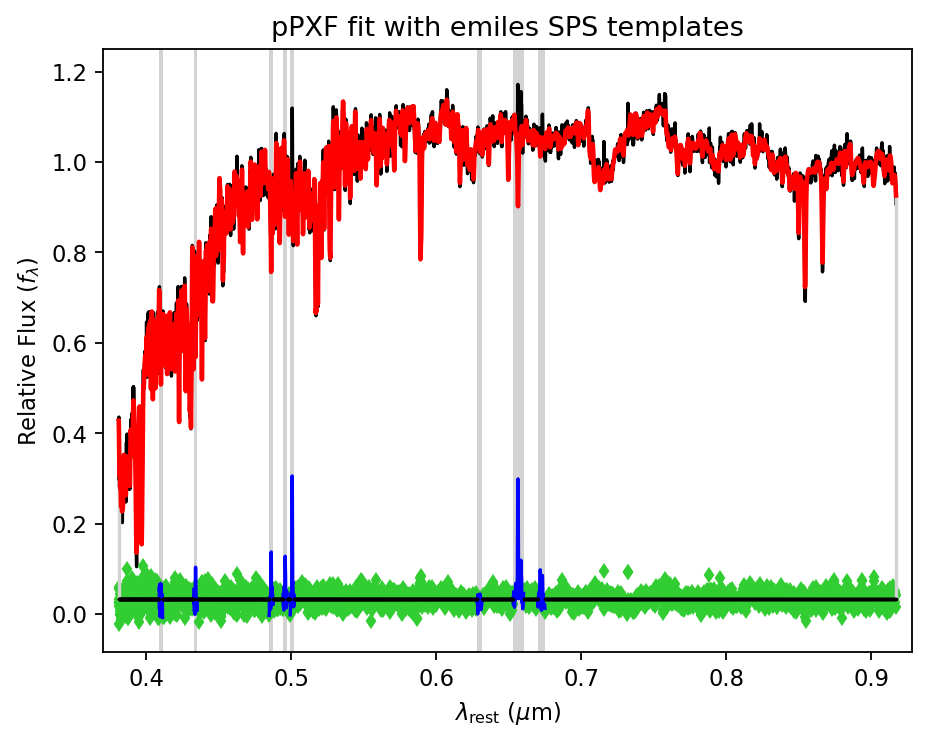

In [12]:
errors = pp.error*np.sqrt(pp.chi2)  # Assume the fit is good chi2/DOF=1
redshift_fit = (1 + redshift_0)*np.exp(pp.sol[0]/c) - 1     # eq. (5c) C23
redshift_err = (1 + redshift_fit)*errors[0]/c               # eq. (5d) C23

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in errors))
prec = int(1 - np.floor(np.log10(redshift_err)))  # two digits of uncertainty
print(f"Best-fitting redshift z = {redshift_fit:#.{prec}f} "
        f"+/- {redshift_err:#.{prec}f}")

pp.plot()
plt.title(f"pPXF fit with {sps_name} SPS templates")
plt.pause(5)